In [1]:
# import libraries
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
import shutil

In [2]:
# paths
train_path = r"C:\Users\Admin\Documents\3rd Year\1st Sem\Machine Learning\Fake Expose\dataset\train"
test_path = r"C:\Users\Admin\Documents\3rd Year\1st Sem\Machine Learning\Fake Expose\dataset\test"
valid_path = r"C:\Users\Admin\Documents\3rd Year\1st Sem\Machine Learning\Fake Expose\dataset\validation"

In [3]:
# directories
train_dir = os.path.join(train_path)
test_dir = os.path.join(test_path)
valid_dir = os.path.join(valid_path)


BATCH_SIZE = 16
IMG_SIZE = (224, 224)

In [4]:
# training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

# test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

# validation dataset
valid_dataset = tf.keras.utils.image_dataset_from_directory(valid_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 6962 files belonging to 2 classes.
Found 1994 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


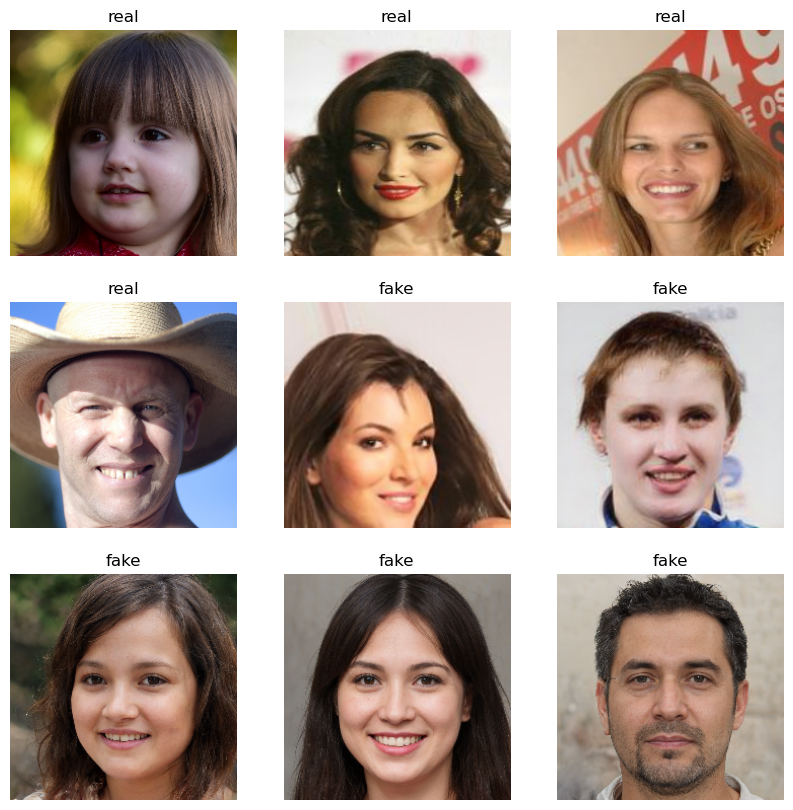

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10,10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [6]:
# configure dataset for performance

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
# data augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    #tf.keras.layers.RandomZoom(0.2),
    #tf.keras.layers.RandomHeight(0.2),
    #tf.keras.layers.RandomWidth(0.2)
])

In [8]:
# rescale according to the base model (VGG16)
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [9]:
# create the base model from VGG16

IMG_SIZE = IMG_SIZE+(3,)
base_model = tf.keras.applications.VGG19(input_shape=IMG_SIZE,
                                         include_top=False,
                                         weights='imagenet')

In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 512)


In [11]:
# feature extraction

# freeze convolutional base
base_model.trainable = False

In [12]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
# classification head

#pooling
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 512)


In [14]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

In [15]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# build model

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [16]:
# compile model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [17]:
# train model
initial_epochs = 20

In [18]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=valid_dataset)

Epoch 1/20
436/436 [==============================] - 123s 262ms/step - loss: 1.3125 - accuracy: 0.5195 - val_loss: 0.8595 - val_accuracy: 0.5970
Epoch 2/20
436/436 [==============================] - 114s 261ms/step - loss: 1.1160 - accuracy: 0.5481 - val_loss: 0.7771 - val_accuracy: 0.6290
Epoch 3/20
436/436 [==============================] - 115s 262ms/step - loss: 1.0314 - accuracy: 0.5745 - val_loss: 0.7257 - val_accuracy: 0.6440
Epoch 4/20
436/436 [==============================] - 115s 264ms/step - loss: 0.9127 - accuracy: 0.5945 - val_loss: 0.6908 - val_accuracy: 0.6530
Epoch 5/20
436/436 [==============================] - 114s 261ms/step - loss: 0.8464 - accuracy: 0.6163 - val_loss: 0.6608 - val_accuracy: 0.6600
Epoch 6/20
436/436 [==============================] - 114s 260ms/step - loss: 0.7875 - accuracy: 0.6330 - val_loss: 0.6405 - val_accuracy: 0.6740
Epoch 7/20
436/436 [==============================] - 115s 264ms/step - loss: 0.7407 - accuracy: 0.6484 - val_loss: 0.6075 -

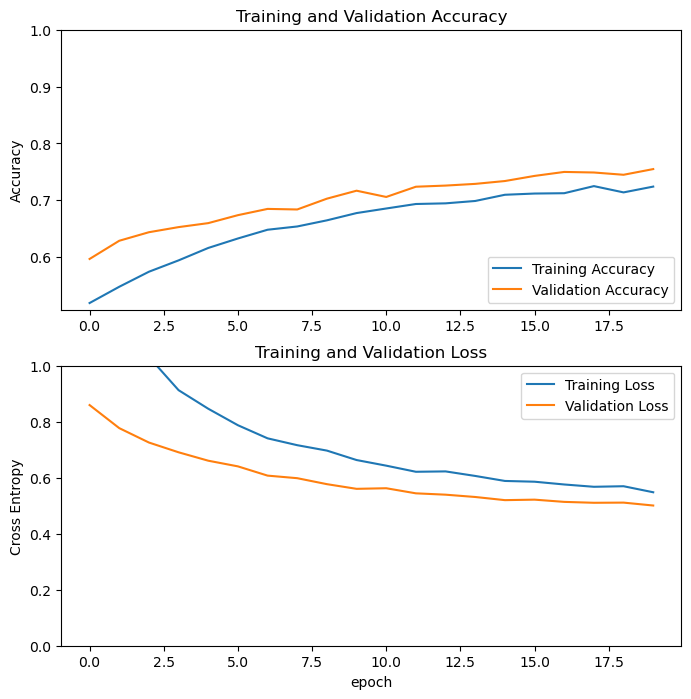

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
# Save the trained model to Google Drive
model_save_path = r'C:\Users\Admin\Documents\3rd Year\1st Sem\Machine Learning\Fake Expose\Models\VGG16.keras'  # Replace with desired save path
model.save(model_save_path)

print(f"Model saved to: {model_save_path}")


Model saved to: C:\Users\Admin\Documents\3rd Year\1st Sem\Machine Learning\Fake Expose\Models\VGG16.keras


Accuracy: 76.03%


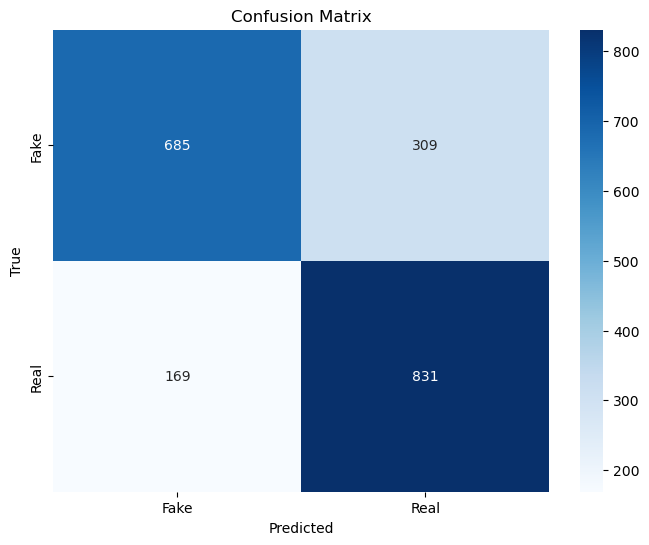

Labels shape: (1994,)
Predictions shape: (1994,)
Accuracy for Fake: 80.21%
Accuracy for Real: 72.89%


In [25]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize empty lists to store predictions and labels
all_predictions = []
all_labels = []

# Loop through the test dataset to get predictions and labels
for image_batch, label_batch in test_dataset:
    # Get model predictions for the current batch
    predictions = model.predict_on_batch(image_batch).flatten()
    
    # Convert predictions to 0 or 1 (binary classification)
    predictions = np.where(predictions < 0.5, 0, 1)  # Assuming a threshold of 0.5 for binary classification
    
    # Convert labels (if necessary) to integers, flatten them
    if len(label_batch.shape) > 1 and label_batch.shape[-1] > 1:  # One-hot encoded labels
        labels = np.argmax(label_batch.numpy(), axis=-1)
    else:
        labels = label_batch.numpy().flatten()
    
    # Append predictions and labels to the respective lists
    all_predictions.extend(predictions)
    all_labels.extend(labels)

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

accuracy = np.mean(all_predictions == all_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Ensure the shapes match for confusion matrix
print("Labels shape:", all_labels.shape)
print("Predictions shape:", all_predictions.shape)

# Extract values from the confusion matrix
tp_class_0 = cm[0, 0]  # True Positives for Class 0
fp_class_0 = cm[0, 1]  # False Positives for Class 0
fn_class_0 = cm[1, 0]  # False Negatives for Class 0
tn_class_0 = cm[1, 1]  # True Negatives for Class 0

tp_class_1 = cm[1, 1]  # True Positives for Class 1
fp_class_1 = cm[1, 0]  # False Positives for Class 1
fn_class_1 = cm[0, 1]  # False Negatives for Class 1
tn_class_1 = cm[0, 0]  # True Negatives for Class 1

# Calculate accuracy for each class
accuracy_class_0 = tp_class_0 / (tp_class_0 + fn_class_0) if (tp_class_0 + fn_class_0) > 0 else 0
accuracy_class_1 = tp_class_1 / (tp_class_1 + fn_class_1) if (tp_class_1 + fn_class_1) > 0 else 0

# Print out the accuracies for each class
print(f"Accuracy for Fake: {accuracy_class_0 * 100:.2f}%")
print(f"Accuracy for Real: {accuracy_class_1 * 100:.2f}%")



In [22]:
# Save the trained model to Google Drive
model_save_path = r'C:\Users\Admin\Documents\3rd Year\1st Sem\Machine Learning\Fake Expose\Models\VGG16.keras'  # Replace with desired save path
model.save(model_save_path)

print(f"Model saved to: {model_save_path}")


Model saved to: C:\Users\Admin\Documents\3rd Year\1st Sem\Machine Learning\Fake Expose\Models\VGG16.keras
